# Facial Detection via Webcam

This project aims at creating a small IA able to detect portrait characteristics : mouth, nose and the face position.

As a beginning, we will take a look inside the database.

This project is made possible by using a preprossed version of the database **YouTube Faces DB**

 Lior Wolf, Tal Hassner and Itay Maoz
*Face Recognition in Unconstrained Videos with Matched Background Similarity.*
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011.

#### Training and Testing Data

This dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images.
* 2308 are test images.


In [2]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

Let's see in what the data base consits by choosing a random image in it.

In [5]:
key_images = pd.read_csv('../data/training_frames_keypoints.csv')

image_name = key_images.iloc[34,0]
key_pts = key_images.iloc[34,1:].values
key_pts = key_pts.astype('float').reshape(-1,2)

print('Name: ', image_name)
print('Shape: ', key_pts.shape)
print('Key pts: {}'.format(key_pts[-4:]))

Name:  Chuck_Woolery_10.jpg
Shape:  (68, 2)
Key pts: [[54. 69.]
 [49. 70.]
 [46. 70.]
 [45. 72.]]


We now print an image with its corresponding key points. To make easier a small function is defined.

In [7]:
def plot_keypoints(image,key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='o', c='m')

Chuck_Woolery_10.jpg


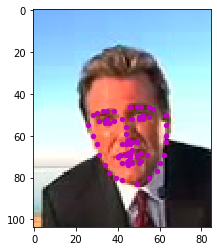

In [13]:
print(image_name)
plot_keypoints(mpimg.imread(os.path.join('../data/training/', image_name)),key_pts)

We need to prepare the data for the training. A dataloader is defined in the *data_gestion.py* file. 
In this file transformation are also defined to improve the data before training.

In [15]:
from data_gestion import ImageDataset, ToTensor, Normalize, RandomCrop, Rescale

We can now define the dataset.

In [ ]:
images_dataset = ImageDataset(file='../data/training_frames_keypoints.csv',dir_='../data/training/')

print('Size: ', len(images_dataset))

And here is what happens if we apply some transformation on a random image in the dataset. 

Agnes_Bruckner_41.jpg


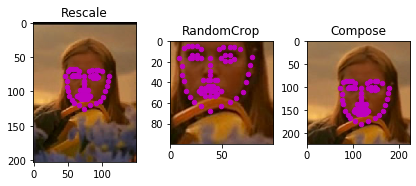

In [25]:
import torch
from torchvision import transforms, utils

rescale = Rescale(150)
crop = RandomCrop(100)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])
print(key_images.iloc[42,0])
example = images_dataset[42]

fig = plt.figure()
for i, j in enumerate([rescale, crop, composed]):
    transformed_sample = j(example)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(j).__name__)
    plot_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

Let's now transform the whole database.

In [28]:
transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

transformed_dataset = ImageDataset(file='../data/training_frames_keypoints.csv',dir_='../data/training/',transform=transform)


To make the detection possible we'll proceed in two phases.

*  Using Haar Cascade Detector we will be able to detect faces in an image.
*  Mouth, nose and face countour will be found applying a Convolutional Neural Network. 

# Faces Detection in an image.

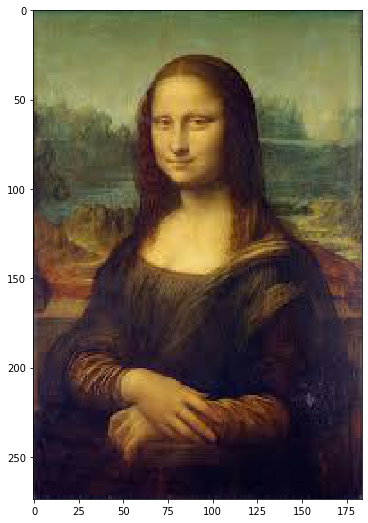

In [72]:
image = cv2.imread('../images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

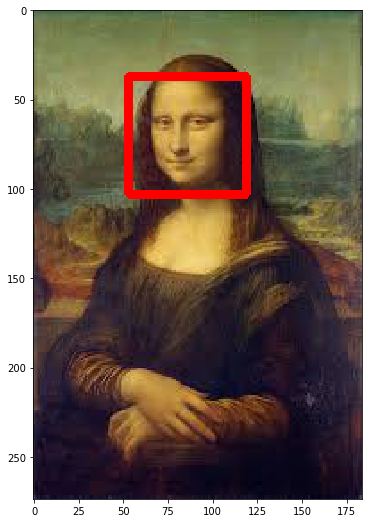

In [74]:
face_cascade = cv2.CascadeClassifier('../detector_architectures/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(image, 1.4, 2)

image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

# CNN Training